# Initial Setups

## Set MSCTD Configurations

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!pip3 install --upgrade gdown
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade --no-cache-dir gdown
# 
!git clone https://github.com/XL2248/MSCTD

!cp MSCTD/MSCTD_data/ende/english_*.txt .
!cp MSCTD/MSCTD_data/ende/image_index_*.txt .
!cp MSCTD/MSCTD_data/ende/sentiment*.txt .

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'MSCTD' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install einops
!pip install pytorch_lightning
!pip install wandb
!pip install ml_collections

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Libraries

In [ ]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cv2
from tqdm import tqdm
from time import localtime
import gc

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from IPython.display import clear_output 
from PIL import Image, ImageOps, ImageEnhance

import pytorch_lightning as pl
import torchvision.datasets as dset
import torchvision.transforms as T
from matplotlib import image as mpimg
from PIL import Image
from PIL import Image, ImageOps, ImageEnhance
from einops import parse_shape, rearrange
from opt_einsum import contract
import math
import functools
import pickle, marshal
from einops import rearrange
from numpy import asarray
import random
import torchvision.transforms as transforms

## Device Configuration

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Create Data Loader Class

In [ ]:
def save_function(function, directory):
    code_string = marshal.dumps(function.__code__)
    with open(directory, 'wb') as file:
        pickle.dump(code_string, file)
    file.close()

In [ ]:
def ToNumpy():
    return pd.DataFrame.to_numpy
def ToTensor():
    return transforms.ToTensor

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, path_label, path_sentiment, path_dialoges, drive_id, mode,transform, image_size, batch_size=None):
    'Initialization'
    self.path_label = path_label
    self.path_sentiment = path_sentiment
    self.path_dialoges = path_dialoges
    self.drive_id = drive_id
    self.mode = mode
    self.image_size = image_size
    self.batch_size = batch_size
    self.ds = self.load_images()
    self.labels = np. asarray(self.read_txt(path_label)[:-1])
    self.indexes = np. asarray(self.conversations_index()[:-1])
    self.dialoges = np. asarray(self.read_txt(path_dialoges)[:-1])
    self.transform = transform
    self.convertType()

  def __len__(self):
    'Denotes the total number of samples'
    return len(self.labels)

  def __getitem__(self, index):
    'Generates one sample of data'
    image_index = self.get_image(index)
    dialoge_index = self.dialoges[index]
    label_index = self.labels[index]
    return image_index, dialoge_index, label_index
  
  def read_txt(self, path_text):
    'Reads text and turn them into a list'
    my_file = open(path_text, "r")
    data = my_file.read()
    data_into_list = data.split("\n")
    return data_into_list

  def load_images(self):
    'download images'
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    file_id = self.drive_id
    file_path = './DLproject'
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    path_zip = '/content/' + self.mode + '.zip'
    !gdown --id "$file_id"
    !unzip "$path_zip" -d '/content/DLproject/'

    img_height, img_width = self.image_size
    dir_files = '/content/DLproject'
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_files, image_size=(img_height, img_width), batch_size=self.batch_size
    )
    return ds

  def get_image(self, index):
    file_name = '/content/DLproject/'+ self.mode + '//'+ str(index) + '.jpg'
    image = cv2.imread(file_name)
    image= np.asarray(image)
    if(self.transform == transforms.ToTensor):
        trans = transforms.Compose([transforms.ToTensor()])
        image = trans(image)

    return image

  def conversations_index(self):
    'map dialoge index to an image'
    my_file = open(self.path_sentiment, "r")
    data = my_file.read()
    conversations = data.split("\n")
    indexes = []
    for i in range(len(conversations)):
      conversation_i = conversations[i]
      conversation_i = conversation_i[1: -1]
      conversation_i = conversation_i.split(",")
      dialoges_per_conversation = len(conversation_i)
      for j in range(dialoges_per_conversation):
        indexes.append(i)
    return indexes

  def convertType(self):
      if(self.transform == transforms.ToTensor):
          self.dialoges = tf.convert_to_tensor(self.dialoges)
          self.indexes = tf.convert_to_tensor(self.indexes)
          self.labels = tf.convert_to_tensor(self.indexes)

## Import Dataset and Create Dataset Object

In [ ]:
classes = ['Neutral', 'Negative', 'Positive']

In [ ]:
id = '1EYjMT2_0EpmZQSbWtsaQOMkP_9Zxt8Ll'
data_loader_train = Dataset('sentiment_train.txt', 'image_index_train.txt', 'english_train.txt', id, 'train_ende',transform=ToNumpy(), image_size=(554,1280), batch_size=64)
clear_output()

In [ ]:
# id = '1_kjhrE_503e1ahPFycIi9sev_7nOq6T3'
# data_loader_test = Dataset('sentiment_test.txt', 'image_index_test.txt', 'english_test.txt', id, 'test',transform=ToTensor(), image_size=(554,1280), batch_size=64)
# clear_output()

In [ ]:
id = '1_kjhrE_503e1ahPFycIi9sev_7nOq6T3'
data_loader_test = Dataset('sentiment_test.txt', 'image_index_test.txt', 'english_test.txt', id, 'test',transform=ToNumpy(),image_size=(554,1280), batch_size=64)
clear_output()

In [ ]:
id = '1SlsoJ0X4C-IK6CQQ7L93Od4MrK6TRPv9'
data_loader_val = Dataset('sentiment_dev.txt', 'image_index_dev.txt', 'english_dev.txt', id, 'dev',transform=ToNumpy(),image_size=(554,1280), batch_size=64)
clear_output()

# Part A

## Part A-1

### Part A-1-1: Detect Face

#### Import Model for Face Recegnition

In [ ]:
!pip install facenet-pytorch

from facenet_pytorch import MTCNN
import cv2

mtcnn = MTCNN(keep_all=True, device=device)

def crop_faces(data_loader: Dataset, face_detector, face_size=(64, 64), skip=1):
    n_faces = []
    faces = []
    labels = []
    frame_index = []
    N = data_loader.__len__()
    for i in tqdm(range(0, N, skip)):
        frame, _, label = data_loader.__getitem__(i)
        boxes, _ = mtcnn.detect(frame)
        if boxes is not None:
            n_faces.append(boxes.shape[0])
            for j in range(boxes.shape[0]):
                a, b, c, d = boxes[j]
                face = frame[round(b):round(d), round(a):round(c)]
                if face.shape[0] > 1 and face.shape[1] > 1:
                    face = cv2.resize(face, dsize=face_size, interpolation=cv2.INTER_CUBIC)
                    faces.append(face)
                    labels.append(label)
                    frame_index.append(i)
    return faces, labels, frame_index

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Detect Face

In [ ]:
train_faces, train_labels, train_frame_index = crop_faces(data_loader_train, mtcnn.detect, face_size=(64, 64), skip=2)

100%|██████████| 10120/10120 [09:03<00:00, 18.60it/s]


In [ ]:
val_faces, val_labels, val_frame_index = crop_faces(data_loader_val, mtcnn.detect, face_size=(64, 64), skip=2)

100%|██████████| 2532/2532 [02:09<00:00, 19.59it/s]


In [ ]:
test_faces, test_labels, test_frame_index = crop_faces(data_loader_test, mtcnn.detect, face_size=(64, 64), skip=2)

100%|██████████| 2534/2534 [02:11<00:00, 19.24it/s]


#### Visulize some faces

In [ ]:
def plot_random_faces(faces, labels):
    r = np.random.randint(0, len(faces), 20)
    plt.figure(figsize=(16, 16))
    for i in range(len(r)):
        plt.subplot(4, 5, i+1)
        face = faces[r[i]]
        plt.imshow(face)
        label_index = int(labels[r[i]])
        plt.title(classes[label_index])

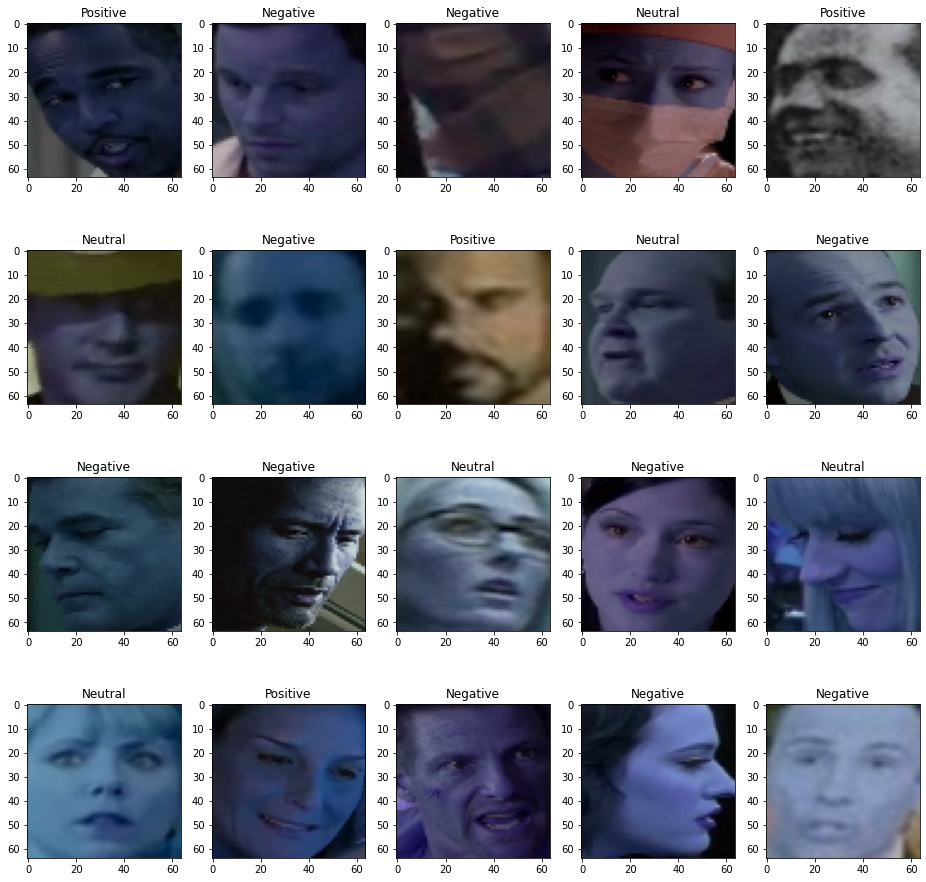

In [ ]:
plot_random_faces(train_faces, train_labels)

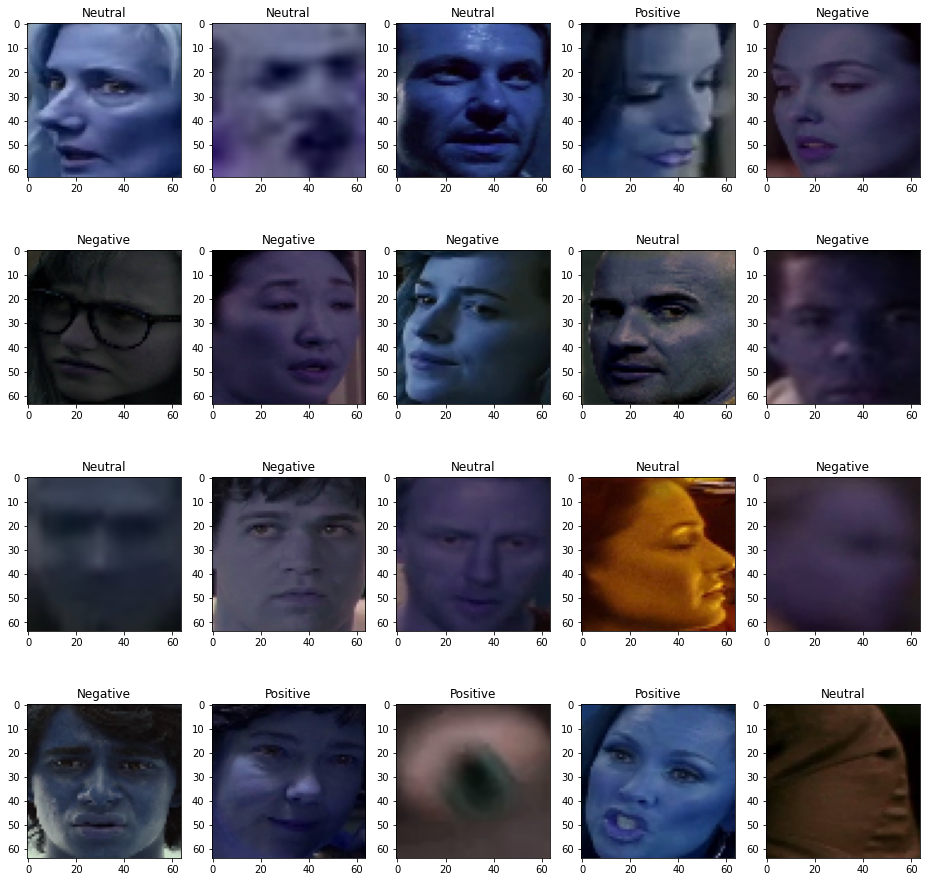

In [ ]:
plot_random_faces(val_faces, val_labels)

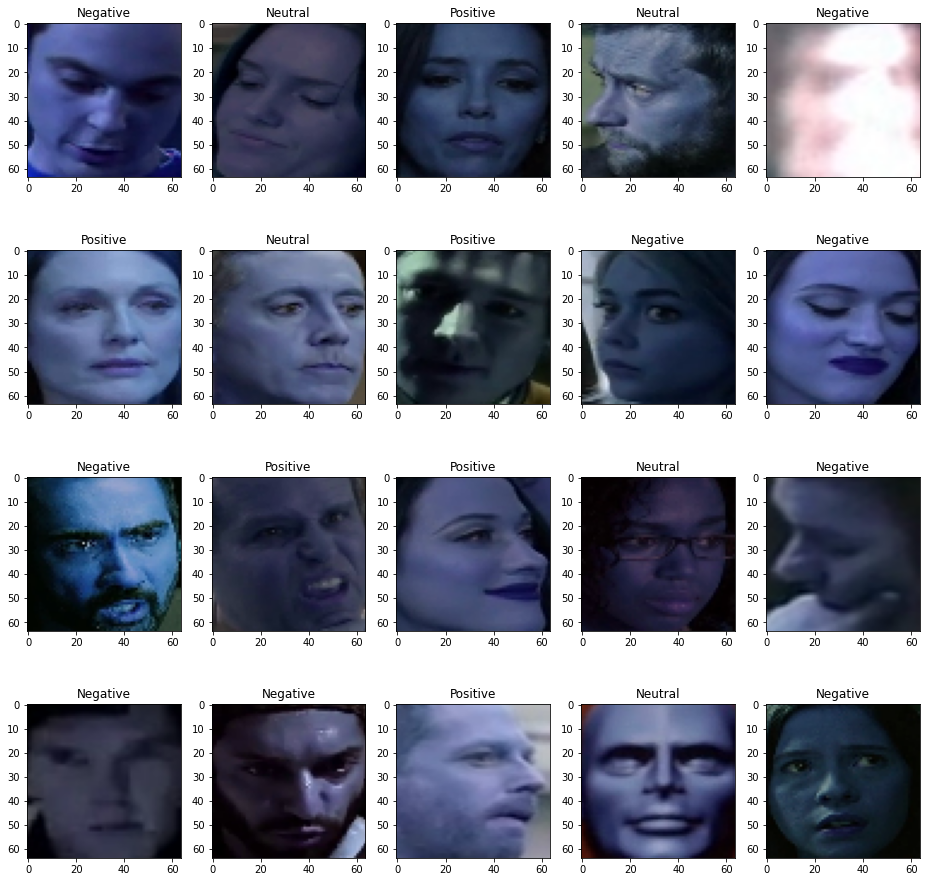

In [ ]:
plot_random_faces(test_faces, test_labels)

### Part A-1-2: CNN Model Pytorch

#### Prepare Data

In [ ]:
def toLabel(x):
    if x == 'Positive' or x == '2':
        return 2
    elif x == 'Negative' or x == '1':
        return 1
    else:
        return 0

print(train_faces[0].shape, val_faces[0].shape, test_faces[0].shape)

train_faces_r = np.zeros((len(train_faces), 3, 64, 64))
val_faces_r = np.zeros((len(val_faces), 3, 64, 64))
test_faces_r = np.zeros((len(test_faces), 3, 64, 64))

if train_faces[0].shape[2] == 3:
    for i in range(len(train_faces)):
        train_faces_r[i] = train_faces[i].T

if val_faces[0].shape[2] == 3:
    for i in range(len(val_faces)):
        val_faces_r[i] = val_faces[i].T

if test_faces[0].shape[2] == 3:
    for i in range(len(test_faces)):
        test_faces_r[i] = test_faces[i].T

print(train_faces_r[0].shape, val_faces_r[0].shape, test_faces_r[0].shape)

y_train = [toLabel(i) for i in train_labels]
y_val = [toLabel(i) for i in val_labels]
y_test = [toLabel(i) for i in test_labels]

x_train = torch.tensor(np.array(train_faces_r), dtype=torch.float32)
y_train = torch.tensor(y_train).type(torch.LongTensor)
x_val = torch.tensor(np.array(val_faces_r), dtype=torch.float32)
y_val = torch.tensor(y_val).type(torch.LongTensor)
x_test = torch.tensor(np.array(test_faces_r), dtype=torch.float32)
y_test = torch.tensor(y_test).type(torch.LongTensor)

train_set = list(map(lambda x, y: (x, y), x_train, y_train))
val_set = list(map(lambda x, y: (x, y), x_val, y_val))
test_set = list(map(lambda x, y: (x, y), x_test, y_test))

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

# del x_train, y_train, x_val, y_val, x_test, y_test, train_set, val_set, test_set
# gc.collect()

(64, 64, 3) (64, 64, 3) (64, 64, 3)
(3, 64, 64) (3, 64, 64) (3, 64, 64)


#### Training Functions

In [ ]:
def train_epoch(net, criterion, optimizer, dataloader):
  epoch_loss = 0
  epoch_true = 0
  epoch_all = 0
  train_loss = 0
  train_accuracy = 0
  i = 0

  net.train()
  for i, (x, y) in enumerate(dataloader):
    x = x.to(device)
    y = y.to(device)
    p = net(x)

    loss = criterion(p, y)
    epoch_loss += float(loss)

    predictions = p.argmax(-1)
    epoch_all += len(predictions)
    epoch_true += (predictions == y).sum()
    
    train_loss = epoch_loss / (i + 1)
    train_accuracy = epoch_true / epoch_all

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

  return train_loss, train_accuracy


def evaluate_epoch(net, criterion, dataloader):
  epoch_loss = 0
  epoch_true = 0
  epoch_all = 0
  eval_loss = 0
  eval_accuracy = 0
  i = 0

  net.eval()
  for i, (x, y) in enumerate(dataloader):
    x = x.to(device)
    y = y.to(device)
    p = net(x)

    loss = criterion(p, y)
    epoch_loss += float(loss)

    predictions = p.argmax(-1)
    epoch_all += len(predictions)
    epoch_true += (predictions == y).sum()

    eval_loss = epoch_loss / (i + 1)
    eval_accuracy = epoch_true / epoch_all

  return eval_loss, eval_accuracy


def getTime():
  loc_time = localtime()
  hour, min, sec = loc_time.tm_hour, loc_time.tm_min, loc_time.tm_sec
  return str(hour) + ":" + str(min) + ":" + str(sec)


def train_model(net, n_epochs, criterion, optimizer, train_loader, test_loader=None, name=''):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    max_test_acc = 0
    if name == '':
        name = 'model.pth'

    for e in range(n_epochs):
        train_loss, train_accuracy = train_epoch(net, criterion, optimizer, train_loader)
        if test_loader is not None:
            test_loss, test_accuracy = evaluate_epoch(net, criterion, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(float(train_accuracy))
        if test_loader is not None:
            test_losses.append(test_loss)
            test_accuracies.append(float(test_accuracy))
            if float(test_accuracy) > max_test_acc:
                max_test_acc = float(test_accuracy)
                torch.save(net, name)

        print(f'[Epoch {e+1}]\t [{getTime()}]\t', end="")
        print(f'Train Loss: {train_loss:.4f}\tTrain Accuracy: {train_accuracy:.2f}\t', end="")
        if test_loader is not None:
            print(f'Test Loss: {test_loss:.4f}\t\tTest Accuracy: {test_accuracy:.2f}')
        else:
            print()
    
    return train_losses, train_accuracies, test_losses, test_accuracies


def test_model(net, criterion, dataloader):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    eval_loss = 0
    eval_accuracy = 0
    i = 0
    with torch.no_grad():
        pred = torch.tensor([]) #.to(device)

        net_cpu = net.to('cpu')
        net.eval()
        for i, (x, y) in enumerate(dataloader):
            # x = x.to(device)
            # y = y.to(device)
            
            p = net(x)
            # y_hat = torch.cat((y_hat, p), 0)
            
            loss = criterion(p, y)
            epoch_loss += float(loss)

            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            eval_loss = epoch_loss / (i + 1)
            eval_accuracy = epoch_true / epoch_all

            pred = torch.cat((pred, predictions), 0)

    return pred, eval_loss, eval_accuracy

In [ ]:
save_function(train_epoch,'train_epoch.pkl' )
save_function(evaluate_epoch,'evaluate_epoch.pkl' )
save_function(getTime,'getTime.pkl' )
save_function(train_model,'train_model.pkl' )
save_function(test_model,'test_model.pkl' )

#### Define Model

In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_space = nn.Sequential( # Input: (B, 3, 64, 64)
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3), # (B, 8, 62, 62)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=1), # (B, 16, 60, 60)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # (B, 32, 30, 30)
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, padding=1), # (B, 64, 26, 26)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1), # (B, 128, 24, 24)
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # (B, 128, 12, 12)
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3), # (B, 256, 10, 10)
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3), # (B, 512, 8, 8)
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4), # (B, 512, 2, 2)
        nn.Flatten(), # (B, 2048)
        nn.Dropout(p=0.2),
        nn.Linear(2048, 64), # (B, 128)
        nn.BatchNorm1d(64),
        nn.ReLU(),
        )
        self.dropout = nn.Dropout(p=0.2)
        self.classifier = nn.Sequential(
            nn.Linear(64, 3),
            nn.Softmax(-1)
        )

    def forward(self, x):
        return self.classifier(self.dropout(self.feature_space(x)))

#### Train Model

In [ ]:
net = MyNet().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-3)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.95)

In [ ]:
train_loss, train_acc, _, _= train_model(net, 15, criterion, optimizer, train_loader, val_loader, name='face_model.pth')

[Epoch 1]	 [22:8:1]	Train Loss: 1.0972	Train Accuracy: 0.37	Test Loss: 1.0943		Test Accuracy: 0.38
[Epoch 2]	 [22:8:7]	Train Loss: 1.0861	Train Accuracy: 0.39	Test Loss: 1.0944		Test Accuracy: 0.38
[Epoch 3]	 [22:8:12]	Train Loss: 1.0756	Train Accuracy: 0.42	Test Loss: 1.0981		Test Accuracy: 0.37
[Epoch 4]	 [22:8:17]	Train Loss: 1.0742	Train Accuracy: 0.42	Test Loss: 1.0985		Test Accuracy: 0.37
[Epoch 5]	 [22:8:23]	Train Loss: 1.0671	Train Accuracy: 0.43	Test Loss: 1.1033		Test Accuracy: 0.35
[Epoch 6]	 [22:8:28]	Train Loss: 1.0613	Train Accuracy: 0.44	Test Loss: 1.1017		Test Accuracy: 0.37
[Epoch 7]	 [22:8:34]	Train Loss: 1.0569	Train Accuracy: 0.45	Test Loss: 1.1018		Test Accuracy: 0.35
[Epoch 8]	 [22:8:39]	Train Loss: 1.0520	Train Accuracy: 0.45	Test Loss: 1.1001		Test Accuracy: 0.38
[Epoch 9]	 [22:8:44]	Train Loss: 1.0404	Train Accuracy: 0.47	Test Loss: 1.1051		Test Accuracy: 0.36
[Epoch 10]	 [22:8:49]	Train Loss: 1.0304	Train Accuracy: 0.49	Test Loss: 1.1131		Test Accuracy: 0.35
[

In [ ]:
net = torch.load('face_model.pth')

#### Evaluate Model

In [ ]:
pred, loss, acc = test_model(net, criterion, test_loader)
print(f'accuracy: {acc}')

accuracy: 0.3785354495048523


In [ ]:
# print(torch.sum(y_test == 0), torch.sum(y_test == 1), torch.sum(y_test == 2))
# print(torch.sum(pred == 0), torch.sum(pred == 1), torch.sum(pred == 2))

### Part A-1-3: Predict for Frames

In [ ]:
def predict_image_emotion(data_loader: Dataset, face_emotion_predict, face_frame_index, prior=[1300, 2100, 1600]):
    y_frame = -torch.ones((data_loader.__len__(),))
    for i in range(data_loader.__len__()):
        y = face_emotion_predict[torch.tensor(face_frame_index) == i]
        if y.shape == (0,):
            r = np.random.randint(1, sum(prior))
            if r < prior[0]:
                y_frame[i] = 0
            elif r < prior[0] + prior[1]:
                y_frame[i] = 1
            else:
                y_frame[i] = 2
        else:
            n = torch.tensor([sum(y == 0), sum(y == 1), sum(y == 2)])
            y_frame[i] = torch.argmax(n)

    y_frame_true = torch.from_numpy(data_loader.labels.astype(np.float32))
    acc = sum(y_frame == y_frame_true) / y_frame.shape[0]
    return y_frame, round(float(acc), 3)

In [ ]:
_, acc = predict_image_emotion(data_loader_test, pred, test_frame_index)
print(f'accuracy: {acc}')

accuracy: 0.364


In [ ]:
save_function(predict_image_emotion,'predict_image_emotion.pkl' )

## Part A-2

### Part A-2-1

#### Some Functions for changing Color, Btightness and Location

In [ ]:
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.0


def sample_level(n):
    return np.random.uniform(low=0.5, high=n)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level=10):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)

# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level=10):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)

#### Random Smooth Color

In [ ]:
class RandomSmoothColor(torch.nn.Module):
    def __init__(self, cut, T, freq_bandwidth=None, stochastic=False, T_min=0.):
        super().__init__()
        self.cut = cut
        self.T = T
        self.freq_bandwidth = freq_bandwidth
        
        self.stochastic = stochastic
        if self.stochastic:
            self.cut_max = cut
            self.T_min = T_min
            self.T_max = T

    def forward(self, img):

        if self.stochastic:
            self._sample_params()

        init_shape = img.shape
        if len(init_shape) < 4:
            img = rearrange(img, "c h w -> () c h w")

        return self.random_smooth_color(img, self.cut, self.T, self.freq_bandwidth).reshape(init_shape)

    def _sample_params(self):
        self.cut = torch.randint(low=1, high=self.cut_max + 1, size=(1,)).item()
        self.T = torch.FloatTensor([1]).uniform_(self.T_min, self.T_max).item()

    def random_smooth_color(self, img, cut, T, freq_bandwidth=None):
        img_shape = parse_shape(img, "b c h w")
        colors = rearrange(img, "b c h w -> b c (h w)")

        if freq_bandwidth is not None:
            min_k = torch.randint(low=1, high=cut + 1, size=(1,)).item()
            k = torch.arange(
                min_k, min(min_k + freq_bandwidth, cut + 1), 
                device=img.device
            )
            coeff = torch.randn(
                (img_shape["b"], img_shape["c"], k.shape[0]), 
                device=img.device
            )
        else:
            coeff = torch.randn(
                (img_shape["b"], img_shape["c"], cut), 
                device=img.device
            )
            k = torch.arange(1, cut + 1, device=img.device)

        coeff = coeff * torch.sqrt(torch.tensor(T))

        freqs = torch.sin(colors[..., None] * k[None, None, None, :] * math.pi)

        # transformed_colors = torch.einsum("bcf,bcnf->bcn", coeff, freqs) + colors
        transformed_colors = contract("bcf, bcnf -> bcn", coeff, freqs) + colors
        transformed_colors = torch.clamp(transformed_colors, 0, 1)

        transformed_image = rearrange(transformed_colors, " b c (h w) -> b c h w", **img_shape)
        return transformed_image

    def __repr__(self):
        return self.__class__.__name__ + f"(T={self.T}, cut={self.cut})"

#### Diffeomorphism

In [ ]:
class Diffeo(torch.nn.Module):
    """Randomly apply a diffeomorphism to the image(s).
    The image should be a Tensor and it is expected to have [..., n, n] shape,
    where ... means an arbitrary number of leading dimensions.
    A random cut is drawn from a discrete Beta distribution of parameters
    alpha and beta such that
        s = alpha + beta (measures how peaked the distribution is)
        r = alpha / beta (measured how biased towards cutmax the distribution is)
    Given cut and the allowed* interval of temperatures [Tmin, Tmax], a random T is
    drawn from a Beta distribution with parameters alpha and beta such that:
        s = alpha + beta (measures how peaked the distribution is)
        r = alpha / beta (measured how biased towards T_max the distribution is)
    Beta ~ delta_function for s -> inf. To apply a specific value x \in [0, 1]
    in the allowed interval of T or cut, set
        - s = 1e10
        - r = x / (1 - x)
    *the allowed T interval is defined such as:
        - Tmin corresponds to a typical displacement of 1/2 pixel in the center
          of the image
        - Tmax corresponds to the highest T for which no overhangs are present.
    Args:
        sT (float):
        rT (float):
        scut (float):
        rcut (float):
        cut_min (int):
        cut_max (int):
    Returns:
        Tensor: Diffeo version of the input image(s).
    """

    def __init__(self, sT, rT, scut, rcut, cutmin, cutmax, alpha, stochastic=False):
        super().__init__()

        self.sT = sT
        self.rT = rT
        self.scut = scut
        self.rcut = rcut
        self.cutmin = cutmin
        self.cutmax = cutmax
        self.alpha = alpha

        self.stochastic = stochastic
        if self.stochastic:
            self.cutmax_max = cutmax
            self.alpha_max = alpha

        self.betaT = torch.distributions.beta.Beta(sT - sT / (rT + 1), sT / (rT + 1), validate_args=None)
        self.betacut = torch.distributions.beta.Beta(scut - scut / (rcut + 1), scut / (rcut + 1), validate_args=None)

    def forward(self, img):
        """
        Args:
            img (Tensor): Image(s) to be 'diffeomorphed'.
        Returns:
            Tensor: Diffeo image(s).
        """

        init_shape = img.shape
        if len(init_shape) < 4:
            img = rearrange(img, "c h w -> () c h w")

        if self.stochastic:
            self._sample_params()

        # image size
        n = img.shape[-1]

        cut = (self.betacut.sample() * (self.cutmax + 1 - self.cutmin) + self.cutmin).int().item()
        T1, T2 = temperature_range(n, cut)
        T2 = max(T1, self.alpha * T2)
        T = (self.betaT.sample() * (T2 - T1) + T1)

        return deform(img, T, cut).reshape(init_shape)

    def _sample_params(self):
        self.cutmax = torch.randint(low=self.cutmin + 1, high=self.cutmax_max + 1, size=(1,)).item()
        # self.alpha = torch.FloatTensor([1]).uniform_(0., self.alpha_max).item()

    def __repr__(self):
        return self.__class__.__name__ + f'(sT={self.sT}, rT={self.rT}, scut={self.scut}, rcut={self.rcut}, cutmin={self.cutmin}, cutmax={self.cutmax})'



@functools.lru_cache()
def scalar_field_modes(n, m, dtype=torch.float64, device='cpu'):
    """
    sqrt(1 / Energy per mode) and the modes
    """
    x = torch.linspace(0, 1, n, dtype=dtype, device=device)
    k = torch.arange(1, m + 1, dtype=dtype, device=device)
    i, j = torch.meshgrid(k, k)
    r = (i.pow(2) + j.pow(2)).sqrt()
    e = (r < m + 0.5) / r
    s = torch.sin(math.pi * x[:, None] * k[None, :])
    return e, s


def scalar_field(n, m, device='cpu'):
    """
    random scalar field of size nxn made of the first m modes
    """
    e, s = scalar_field_modes(n, m, dtype=torch.get_default_dtype(), device=device)
    c = torch.randn(m, m, device=device) * e
    # return torch.einsum('ij,xi,yj->yx', c, s, s)
    return contract('ij,xi,yj->yx', c, s, s)


def deform(image, T, cut, interp='linear'):
    """
    1. Sample a displacement field tau: R2 -> R2, using tempertature `T` and cutoff `cut`
    2. Apply tau to `image`
    :param img Tensor: square image(s) [..., y, x]
    :param T float: temperature
    :param cut int: high frequency cutoff
    """
    n = image.shape[-1]
    assert image.shape[-2] == n, 'Image(s) should be square.'

    device = image.device

    # Sample dx, dy
    # u, v are defined in [0, 1]^2
    # dx, dx are defined in [0, n]^2
    u = scalar_field(n, cut, device)  # [n,n]
    v = scalar_field(n, cut, device)  # [n,n]
    dx = T ** 0.5 * u * n
    dy = T ** 0.5 * v * n

    # Apply tau
    return remap(image, dx, dy, interp)


def remap(a, dx, dy, interp):
    """
    :param a: Tensor of shape [..., y, x]
    :param dx: Tensor of shape [y, x]
    :param dy: Tensor of shape [y, x]
    :param interp: interpolation method
    """
    n, m = a.shape[-2:]
    assert dx.shape == (n, m) and dy.shape == (n, m), 'Image(s) and displacement fields shapes should match.'

    y, x = torch.meshgrid(torch.arange(n, dtype=dx.dtype, device=a.device), torch.arange(m, dtype=dx.dtype, device=a.device))

    xn = (x - dx).clamp(0, m-1)
    yn = (y - dy).clamp(0, n-1)

    if interp == 'linear':
        xf = xn.floor().long()
        yf = yn.floor().long()
        xc = xn.ceil().long()
        yc = yn.ceil().long()

        xv = xn - xf
        yv = yn - yf

        return (1-yv)*(1-xv)*a[..., yf, xf] + (1-yv)*xv*a[..., yf, xc] + yv*(1-xv)*a[..., yc, xf] + yv*xv*a[..., yc, xc]

    if interp == 'gaussian':
        # can be implemented more efficiently by adding a cutoff to the Gaussian
        sigma = 0.4715

        dx = (xn[:, :, None, None] - x)
        dy = (yn[:, :, None, None] - y)

        c = (-dx**2 - dy**2).div(2 * sigma**2).exp()
        c = c / c.sum([2, 3], keepdim=True)

        return (c * a[..., None, None, :, :]).sum([-1, -2])


def temperature_range(n, cut):
    """
    Define the range of allowed temperature
    for given image size and cut.
    """
    if cut == 0:
        print("Cut is zero!")
    if isinstance(cut, (float, int)):
        cut = cut + 1e-6
        log = math.log(cut)
    else:
        log = cut.log()
    T1 = 1 / (math.pi * n ** 2 * log)
    T2 = 4 / (math.pi ** 3 * cut ** 2 * log)
    return T1, T2


def typical_displacement(T, cut, n):
    if isinstance(cut, (float, int)):
        log = math.log(cut)
    else:
        log = cut.log()
    return n * (math.pi * T * log) ** .5 / 2


#### Mixing changes

In [ ]:
def mixPic(image , size):
    color_num = random.randint(1, 4)
    brightness_num = random.randint(1, 2)
    position_num = random.randint(1, 2)
    #print("color_num ",color_num)
    #print("brightness_num ",brightness_num)
    #print("position_num  ",position_num )
    im_total_1 = []
    im_total_2 = [] 
    im_total_3 = []
    sT = 1.
    rT = 1.
    scut = 1.
    rcut = 1.
    cutmin = 2
    cutmax = 500
    alpha = 1.0
    if (color_num == 1):
        im_total_1 = equalize(image, _)
    elif (color_num == 2):
        im_total_1 = solarize(image, random.randint(3, 10))
    elif (color_num == 3):
        im_total_1 = color(image, random.randint(1, 15))
    elif (color_num == 4):
        im_total_1 = sharpness(image, random.randint(100, 500))
    if (brightness_num == 1):
        im_total_2 = contrast(im_total_1, random.randint(10, 30))
    elif (brightness_num == 2):
        im_total_2 = brightness(im_total_1, level=random.randint(10, 30))
    if (position_num == 1):
        im_total_3 = asarray(im_total_2.rotate(random.randint(10, 95)))/ 255
    elif (position_num == 2):
        diffeo = Diffeo(sT=sT, rT=rT,scut=scut, rcut=rcut, cutmin=cutmin, cutmax=cutmax, alpha=alpha, stochastic=True)
        x = T.ToTensor()(im_total_2)
        im_total_3 = asarray(diffeo(x).permute(1, 2, 0))

    return  im_total_3.astype(np.float32)

#### Finding Augmented Picture

In [ ]:
def augmentationImg(faces , size):
    aug_X=[]
    for i in range(len(faces)):
        aug_X.append(mixPic(Image.fromarray(np.uint8(faces[i])),size))
    #aug_X = np.array(aug_X) 
    return aug_X 

In [ ]:
size = 64
aug_train_faces = augmentationImg(train_faces , size)
aug_val_faces = augmentationImg(val_faces , size)
aug_test_faces = augmentationImg(test_faces , size)
mix_train_faces = [*train_faces,*aug_train_faces]
mix_val_faces = [*val_faces,*aug_val_faces]
mix_test_faces = [*test_faces,*aug_test_faces]

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


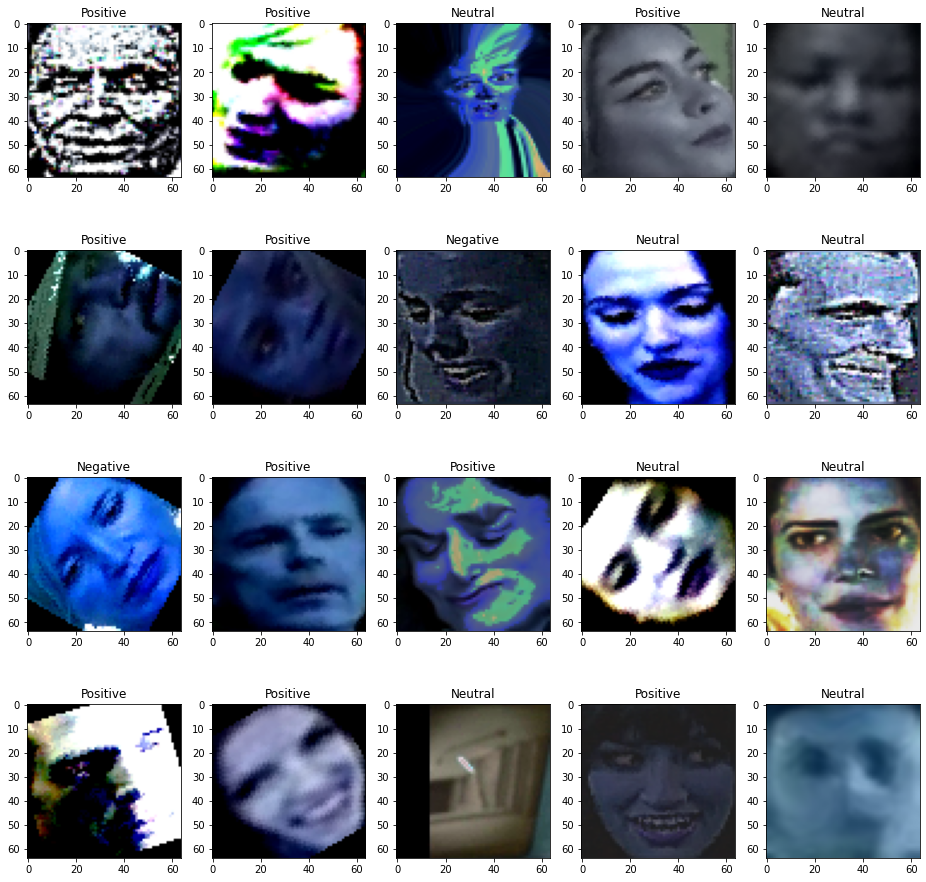

In [ ]:
plot_random_faces(aug_train_faces, train_labels)

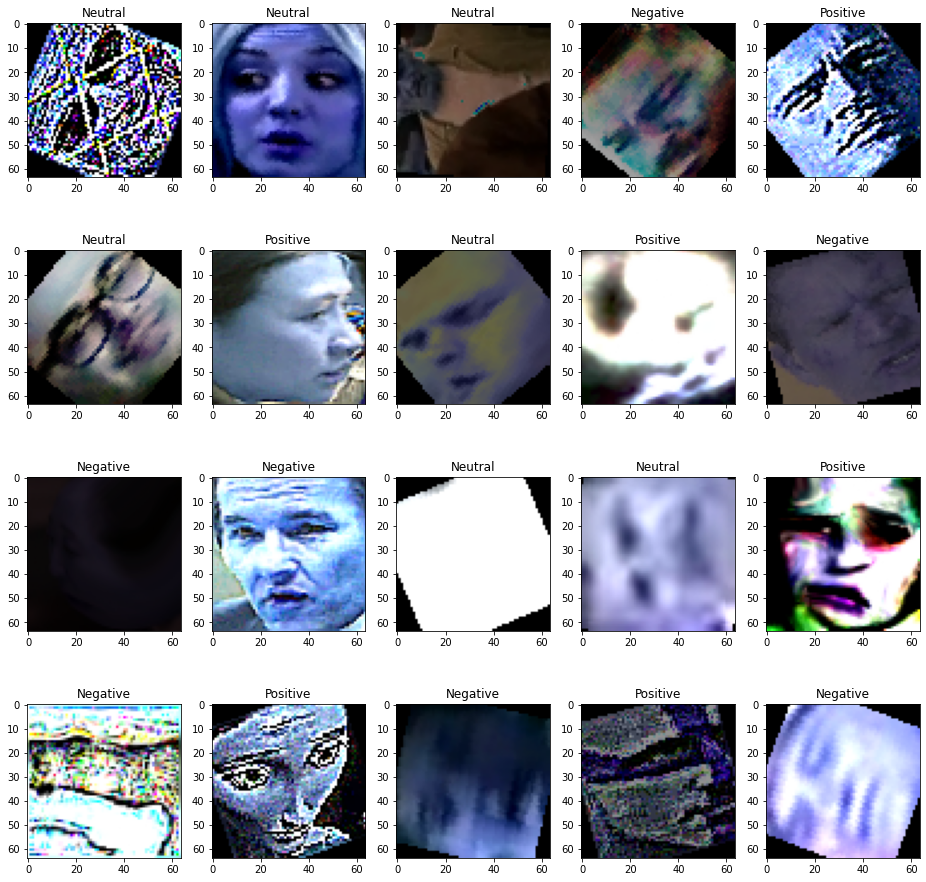

In [ ]:
plot_random_faces(aug_val_faces, val_labels)

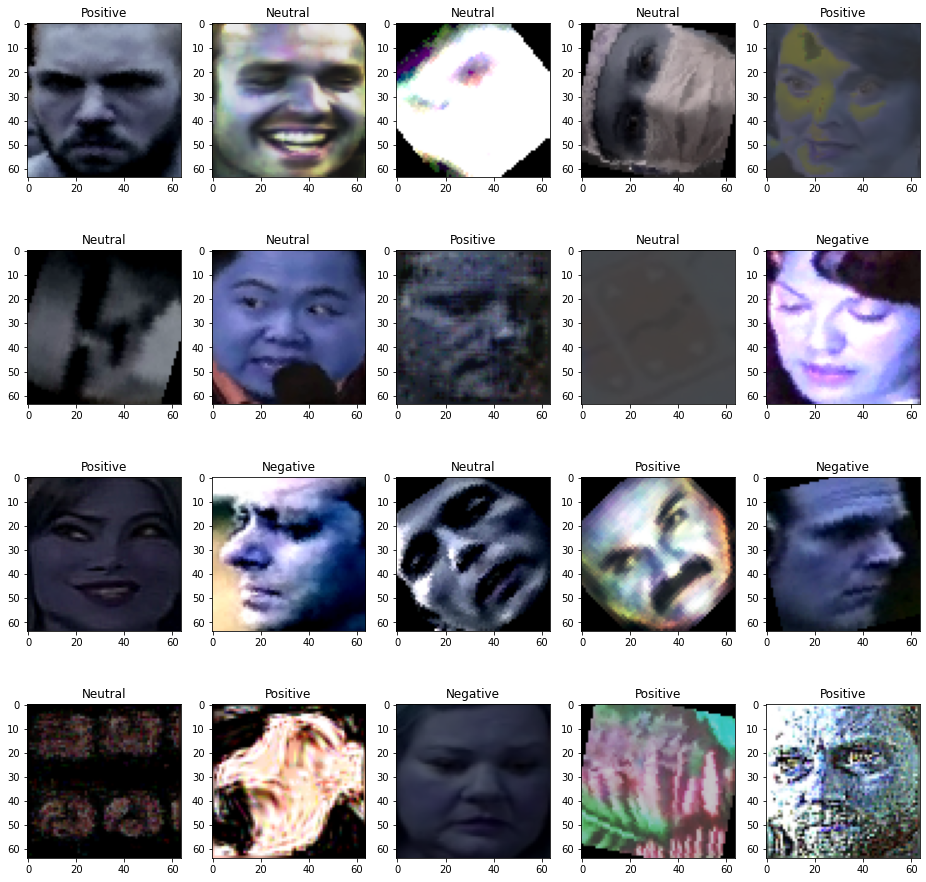

In [ ]:
plot_random_faces(aug_test_faces, test_labels)

### Part A-2-2

In [ ]:

print(aug_train_faces[0].shape, aug_val_faces[0].shape, aug_test_faces[0].shape)

if aug_train_faces[0].shape[2] == 3:
    for i in range(len(aug_train_faces)):
        aug_train_faces[i] = aug_train_faces[i].T

if aug_val_faces[0].shape[2] == 3:
    for i in range(len(aug_val_faces)):
        aug_val_faces[i] = aug_val_faces[i].T

if aug_test_faces[0].shape[2] == 3:
    for i in range(len(aug_test_faces)):
        aug_test_faces[i] = aug_test_faces[i].T

print(aug_train_faces[0].shape, aug_val_faces[0].shape, aug_test_faces[0].shape)

aug_x_train = torch.tensor(np.array(aug_train_faces), dtype=torch.float32)
aug_x_val = torch.tensor(np.array(aug_val_faces), dtype=torch.float32)
aug_x_test = torch.tensor(np.array(aug_test_faces), dtype=torch.float32)

y_train = [toLabel(i) for i in train_labels]
y_val = [toLabel(i) for i in val_labels]
y_test = [toLabel(i) for i in test_labels]

y_train = torch.tensor(y_train).type(torch.LongTensor)
y_val = torch.tensor(y_val).type(torch.LongTensor)
y_test = torch.tensor(y_test).type(torch.LongTensor)

aug_train_set = list(map(lambda x, y: (x, y), aug_x_train, y_train))
aug_val_set = list(map(lambda x, y: (x, y), aug_x_val, y_val))
aug_test_set = list(map(lambda x, y: (x, y), aug_x_test, y_test))

batch_size = 128

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=batch_size, shuffle=True, num_workers=2)
aug_val_loader = torch.utils.data.DataLoader(aug_val_set, batch_size=batch_size, shuffle=True, num_workers=2)
aug_test_loader = torch.utils.data.DataLoader(aug_test_set, batch_size=batch_size, shuffle=True, num_workers=2)

(64, 64, 3) (64, 64, 3) (64, 64, 3)
(3, 64, 64) (3, 64, 64) (3, 64, 64)


In [ ]:
#net = MyNet().to(device)
net = net.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-4)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, train_acc, _, _= train_model(net, 15, criterion, optimizer, aug_train_loader, aug_val_loader, 'face_aug_model.pth')

[Epoch 1]	 [22:16:1]	Train Loss: 1.0621	Train Accuracy: 0.44	Test Loss: 1.0950		Test Accuracy: 0.37
[Epoch 2]	 [22:16:6]	Train Loss: 1.0553	Train Accuracy: 0.45	Test Loss: 1.0961		Test Accuracy: 0.37
[Epoch 3]	 [22:16:12]	Train Loss: 1.0462	Train Accuracy: 0.48	Test Loss: 1.0982		Test Accuracy: 0.37
[Epoch 4]	 [22:16:17]	Train Loss: 1.0412	Train Accuracy: 0.48	Test Loss: 1.1014		Test Accuracy: 0.37
[Epoch 5]	 [22:16:22]	Train Loss: 1.0307	Train Accuracy: 0.50	Test Loss: 1.0968		Test Accuracy: 0.35
[Epoch 6]	 [22:16:27]	Train Loss: 1.0232	Train Accuracy: 0.51	Test Loss: 1.1024		Test Accuracy: 0.37
[Epoch 7]	 [22:16:33]	Train Loss: 1.0140	Train Accuracy: 0.53	Test Loss: 1.1087		Test Accuracy: 0.35
[Epoch 8]	 [22:16:38]	Train Loss: 1.0042	Train Accuracy: 0.54	Test Loss: 1.1050		Test Accuracy: 0.37
[Epoch 9]	 [22:16:43]	Train Loss: 0.9971	Train Accuracy: 0.55	Test Loss: 1.1062		Test Accuracy: 0.36
[Epoch 10]	 [22:16:48]	Train Loss: 0.9826	Train Accuracy: 0.57	Test Loss: 1.1057		Test Accura

In [ ]:
net = torch.load('face_aug_model.pth')

In [ ]:
aug_y_pred, loss, acc = test_model(net, criterion, aug_test_loader)
print(f'accuracy: {acc}')

accuracy: 0.3680743873119354


In [ ]:
_, acc = predict_image_emotion(data_loader_test, aug_y_pred, test_frame_index)
print(f'accuracy: {acc}')

accuracy: 0.37


### Part A-2-3

In [ ]:
print(mix_train_faces[0].shape, mix_val_faces[0].shape, mix_test_faces[0].shape)

if mix_train_faces[0].shape[2] == 3:
    for i in range(len(mix_train_faces)):
        mix_train_faces[i] = mix_train_faces[i].T

if mix_val_faces[0].shape[2] == 3:
    for i in range(len(mix_val_faces)):
        mix_val_faces[i] = mix_val_faces[i].T

if mix_test_faces[0].shape[2] == 3:
    for i in range(len(mix_test_faces)):
        mix_test_faces[i] = mix_test_faces[i].T

print(mix_train_faces[0].shape, mix_val_faces[0].shape, mix_test_faces[0].shape)

mix_x_train = torch.tensor(np.array(mix_train_faces), dtype=torch.float32)
mix_x_val = torch.tensor(np.array(mix_val_faces), dtype=torch.float32)
mix_x_test = torch.tensor(np.array(mix_test_faces), dtype=torch.float32)

y_train = [toLabel(i) for i in train_labels]
y_val = [toLabel(i) for i in val_labels]
y_test = [toLabel(i) for i in test_labels]
mix_y_train = [*y_train,*y_train]
mix_y_val = [*y_val,*y_val]
mix_y_test = [*y_test,*y_test]
y_train = torch.tensor(y_train).type(torch.LongTensor)
y_val = torch.tensor(y_val).type(torch.LongTensor)
y_test = torch.tensor(y_test).type(torch.LongTensor)

mix_y_train = torch.tensor(mix_y_train).type(torch.LongTensor)
mix_y_val = torch.tensor(mix_y_val).type(torch.LongTensor)
mix_y_test = torch.tensor(mix_y_test).type(torch.LongTensor)

mix_train_set = list(map(lambda x, y: (x, y), mix_x_train, mix_y_train))
mix_val_set = list(map(lambda x, y: (x, y), mix_x_val, mix_y_val))
mix_test_set = list(map(lambda x, y: (x, y), mix_x_test, mix_y_test))

batch_size = 128

mix_train_loader = torch.utils.data.DataLoader(mix_train_set, batch_size=batch_size, shuffle=True, num_workers=2)
mix_val_loader = torch.utils.data.DataLoader(mix_val_set, batch_size=batch_size, shuffle=True, num_workers=2)
mix_test_loader = torch.utils.data.DataLoader(mix_test_set, batch_size=batch_size, shuffle=True, num_workers=2)

(64, 64, 3) (64, 64, 3) (64, 64, 3)
(3, 64, 64) (3, 64, 64) (3, 64, 64)


In [ ]:
#net = MyNet().to(device)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-4)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.95)

train_loss, train_acc, _, _= train_model(net, 10, criterion, optimizer, mix_train_loader, mix_val_loader, 'face_mix_model.pth')

[Epoch 1]	 [22:33:59]	Train Loss: 1.0462	Train Accuracy: 0.45	Test Loss: 1.1048		Test Accuracy: 0.35
[Epoch 2]	 [22:34:9]	Train Loss: 1.0445	Train Accuracy: 0.45	Test Loss: 1.1033		Test Accuracy: 0.36
[Epoch 3]	 [22:34:19]	Train Loss: 1.0383	Train Accuracy: 0.46	Test Loss: 1.0991		Test Accuracy: 0.37
[Epoch 4]	 [22:34:29]	Train Loss: 1.0284	Train Accuracy: 0.47	Test Loss: 1.1009		Test Accuracy: 0.36
[Epoch 5]	 [22:34:39]	Train Loss: 1.0221	Train Accuracy: 0.48	Test Loss: 1.1087		Test Accuracy: 0.36
[Epoch 6]	 [22:34:49]	Train Loss: 1.0143	Train Accuracy: 0.49	Test Loss: 1.1064		Test Accuracy: 0.35
[Epoch 7]	 [22:34:58]	Train Loss: 1.0073	Train Accuracy: 0.49	Test Loss: 1.1098		Test Accuracy: 0.36
[Epoch 8]	 [22:35:8]	Train Loss: 0.9990	Train Accuracy: 0.51	Test Loss: 1.1108		Test Accuracy: 0.36
[Epoch 9]	 [22:35:18]	Train Loss: 0.9904	Train Accuracy: 0.51	Test Loss: 1.1179		Test Accuracy: 0.35
[Epoch 10]	 [22:35:27]	Train Loss: 0.9878	Train Accuracy: 0.51	Test Loss: 1.1100		Test Accura

In [ ]:
net = torch.load('face_mix_model.pth')

In [ ]:
mix_y_pred, loss, acc = test_model(net, criterion, mix_test_loader)
print(f'accuracy: {acc}')

accuracy: 0.3944207727909088


In [ ]:
_, acc = predict_image_emotion(data_loader_test, mix_y_pred[:len(pred-1)], test_frame_index)
print(f'accuracy: {acc}')

accuracy: 0.353


In [ ]:
del mix_x_train, mix_train_set, mix_train_loader
del mix_x_val, mix_val_set, mix_val_loader
del mix_x_test, mix_test_set, mix_test_loader

gc.collect()

8

In [ ]:
del aug_x_train, aug_train_set, aug_train_loader
del aug_x_val, aug_val_set, aug_val_loader
del aug_x_test, aug_test_set, aug_test_loader

gc.collect()

0

#### Result

In both sections, due to the addition of the new dataset, the percentage of accuracy increases, and in the last section, because we have the most variety of data, we reach the highest accuracy.
Data augmentation is useful to improve the performance and outcomes of machine learning models by forming new and different examples to train datasets. If the dataset in a machine learning model is rich and sufficient, the model performs better and more accurately

### Free RAM

In [ ]:
os.kill(os.getpid(), 9)

# Part B

## Part B-1

#### Import Libraries

In [ ]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cv2
from tqdm import tqdm
from time import localtime
import gc

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from IPython.display import clear_output 
from PIL import Image, ImageOps, ImageEnhance

import pytorch_lightning as pl
import torchvision.datasets as dset
import torchvision.transforms as T
from matplotlib import image as mpimg
from PIL import Image
from PIL import Image, ImageOps, ImageEnhance
from einops import parse_shape, rearrange
from opt_einsum import contract
import math
import functools
import pickle, marshal
from einops import rearrange
from numpy import asarray
import random
import torchvision.transforms as transforms

#### Device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Functions

In [ ]:
def ToNumpy():
    return pd.DataFrame.to_numpy
def ToTensor():
    return transforms.ToTensor

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, path_label, path_sentiment, path_dialoges, drive_id, mode,transform, image_size, batch_size=None , unzip = True):
    'Initialization'
    self.unzip = unzip
    self.path_label = path_label
    self.path_sentiment = path_sentiment
    self.path_dialoges = path_dialoges
    self.drive_id = drive_id
    self.mode = mode
    self.image_size = image_size
    self.batch_size = batch_size
    self.ds = self.load_images()
    self.labels = np. asarray(self.read_txt(path_label)[:-1])
    self.indexes = np. asarray(self.conversations_index()[:-1])
    self.dialoges = np. asarray(self.read_txt(path_dialoges)[:-1])
    self.transform = transform
    self.convertType()

  def __len__(self):
    'Denotes the total number of samples'
    return len(self.labels)

  def __getitem__(self, index):
    'Generates one sample of data'
    image_index = self.get_image(index)
    dialoge_index = self.dialoges[index]
    label_index = self.labels[index]
    return image_index, dialoge_index, label_index
  
  def read_txt(self, path_text):
    'Reads text and turn them into a list'
    my_file = open(path_text, "r")
    data = my_file.read()
    data_into_list = data.split("\n")
    return data_into_list

  def load_images(self):
    'download images'
    if(self.unzip == True):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)
        file_id = self.drive_id
        file_path = './DLproject'
        if not os.path.exists(file_path):
            os.makedirs(file_path)
        path_zip = '/content/' + self.mode + '.zip'
        !gdown --id "$file_id "
        !unzip "$path_zip" -d '/content/DLproject/'

    img_height, img_width = self.image_size
    dir_files = '/content/DLproject'
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_files, image_size=(img_height, img_width), batch_size=self.batch_size
    )
    return ds

  def get_image(self, index):
    file_name = '/content/DLproject/'+ self.mode + '//'+ str(index) + '.jpg'
    image = cv2.imread(file_name)
    image= np.asarray(image)
    if(self.transform == transforms.ToTensor):
        trans = transforms.Compose([transforms.ToTensor()])
        image = trans(image)

    return image

  def conversations_index(self):
    'map dialoge index to an image'
    my_file = open(self.path_sentiment, "r")
    data = my_file.read()
    conversations = data.split("\n")
    indexes = []
    for i in range(len(conversations)):
      conversation_i = conversations[i]
      conversation_i = conversation_i[1: -1]
      conversation_i = conversation_i.split(",")
      dialoges_per_conversation = len(conversation_i)
      for j in range(dialoges_per_conversation):
        indexes.append(i)
    return indexes

  def convertType(self):
      if(self.transform == transforms.ToTensor):
          self.dialoges = tf.convert_to_tensor(self.dialoges)
          self.indexes = tf.convert_to_tensor(self.indexes)
          self.labels = tf.convert_to_tensor(self.indexes)

In [ ]:
from skimage import color
def get_data(data_loader: Dataset, frame_size = (128, 128),skip=1 ):
    labels = []
    frames = []
    N = data_loader.__len__()
    for i in tqdm(range(0, N, skip)):
        frame, _, label = data_loader.__getitem__(i)
        frames.append(cv2.resize(frame, dsize = frame_size).astype('float32'))
        labels.append(label)
    return frames , labels

#### Data

In [ ]:
id = '1EYjMT2_0EpmZQSbWtsaQOMkP_9Zxt8Ll'
data_loader_train = Dataset('sentiment_train.txt', 'image_index_train.txt', 'english_train.txt', id, 'train_ende',transform=ToNumpy(), image_size=(554,1280), batch_size=64 , unzip = False)
clear_output()

In [ ]:
id = '1_kjhrE_503e1ahPFycIi9sev_7nOq6T3'
data_loader_test = Dataset('sentiment_test.txt', 'image_index_test.txt', 'english_test.txt', id, 'test',transform=ToNumpy(),image_size=(554,1280), batch_size=64, unzip = False)
clear_output()

In [ ]:
id = '1SlsoJ0X4C-IK6CQQ7L93Od4MrK6TRPv9'
data_loader_val = Dataset('sentiment_dev.txt', 'image_index_dev.txt', 'english_dev.txt', id, 'dev',transform=ToNumpy(),image_size=(554,1280), batch_size=64, unzip = False)
clear_output()

In [ ]:
train_frames , train_labels = get_data(data_loader_train, skip=2)
val_frames , val_labels = get_data(data_loader_val, skip=2)
test_frames , test_labels = get_data(data_loader_test, skip=2)

100%|██████████| 2534/2534 [00:20<00:00, 121.31it/s]


#### Processing Data

In [ ]:
def toLabel(x):
    if x == 'Positive' or x == '2':
        return 2
    elif x == 'Negative' or x == '1':
        return 1
    else:
        return 0

print(train_frames[0].shape, val_frames[0].shape, test_frames[0].shape)

train_frames_r = np.zeros((len(train_frames), 3, 128 , 128))
val_frames_r = np.zeros((len(val_frames), 3, 128 , 128))
test_frames_r = np.zeros((len(test_frames), 3, 128, 128))

if train_frames[0].shape[2] == 3:
    for i in range(len(train_frames)):
        train_frames_r[i] = train_frames[i].T

if val_frames[0].shape[2] == 3:
    for i in range(len(val_frames)):
        val_frames_r[i] = val_frames[i].T

if test_frames[0].shape[2] == 3:
    for i in range(len(test_frames)):
        test_frames_r[i] = test_frames[i].T

print(train_frames_r[0].shape, val_frames_r[0].shape, test_frames_r[0].shape)

y_train = [toLabel(i) for i in train_labels]
y_val = [toLabel(i) for i in val_labels]
y_test = [toLabel(i) for i in test_labels]

x_train = torch.tensor(np.array(train_frames_r), dtype=torch.float32)
y_train = torch.tensor(y_train).type(torch.LongTensor)
x_val = torch.tensor(np.array(val_frames_r), dtype=torch.float32)
y_val = torch.tensor(y_val).type(torch.LongTensor)
x_test = torch.tensor(np.array(test_frames_r), dtype=torch.float32)
y_test = torch.tensor(y_test).type(torch.LongTensor)

train_set = list(map(lambda x, y: (x, y), x_train, y_train))
val_set = list(map(lambda x, y: (x, y), x_val, y_val))
test_set = list(map(lambda x, y: (x, y), x_test, y_test))

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2 )
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

(128, 128, 3) (128, 128, 3) (128, 128, 3)
(3, 128, 128) (3, 128, 128) (3, 128, 128)


In [ ]:
import pickle, marshal, types
def load_function(directory):
    with open(directory, 'rb') as file:
        myvar = pickle.load(file)
        code = marshal.loads(myvar)
        func = types.FunctionType(code, globals(), "name")
    return func

## Part B-2

In [ ]:
train_epoch = train_epoch = load_function('train_epoch.pkl' )
evaluate_epoch = load_function('evaluate_epoch.pkl')
getTime = load_function('getTime.pkl')
predict_image_emotion = load_function('predict_image_emotion.pkl')
train_model = load_function('train_model.pkl')
test_model = load_function('test_model.pkl')

In [ ]:
import torchvision.models as models
from torch import nn, optim
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
   param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 3)
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
resnet = resnet.to(device)

## Part B-3

In [ ]:
train_loss, train_acc, _, _= train_model(resnet, 15, criterion, optimizer, train_loader, val_loader, name='res_model.pth')

[Epoch 1]	 [22:43:27]	Train Loss: 1.4213	Train Accuracy: 0.35	Test Loss: 1.3073		Test Accuracy: 0.35
[Epoch 2]	 [22:43:42]	Train Loss: 1.4072	Train Accuracy: 0.37	Test Loss: 1.2781		Test Accuracy: 0.35
[Epoch 3]	 [22:43:57]	Train Loss: 1.3278	Train Accuracy: 0.38	Test Loss: 1.4564		Test Accuracy: 0.34
[Epoch 4]	 [22:44:12]	Train Loss: 1.4343	Train Accuracy: 0.38	Test Loss: 1.5369		Test Accuracy: 0.37
[Epoch 5]	 [22:44:27]	Train Loss: 1.3304	Train Accuracy: 0.40	Test Loss: 1.9509		Test Accuracy: 0.34
[Epoch 6]	 [22:44:42]	Train Loss: 1.3792	Train Accuracy: 0.40	Test Loss: 1.8164		Test Accuracy: 0.37
[Epoch 7]	 [22:44:57]	Train Loss: 1.5592	Train Accuracy: 0.40	Test Loss: 1.4465		Test Accuracy: 0.35
[Epoch 8]	 [22:45:12]	Train Loss: 1.3038	Train Accuracy: 0.42	Test Loss: 2.2435		Test Accuracy: 0.29
[Epoch 9]	 [22:45:27]	Train Loss: 1.3531	Train Accuracy: 0.42	Test Loss: 1.5504		Test Accuracy: 0.31
[Epoch 10]	 [22:45:42]	Train Loss: 1.3512	Train Accuracy: 0.41	Test Loss: 1.7351		Test Accu

In [ ]:
resnet = torch.load('res_model.pth')

In [ ]:
del train_loader
gc.collect()

34

In [ ]:
del val_loader
gc.collect()

0

In [ ]:
pred, loss, acc = test_model(resnet, criterion, test_loader)
print(f'accuracy: {acc}')

accuracy: 0.41436463594436646


### Free RAM

In [ ]:
os.kill(os.getpid(), 9)

# Part C

#### Imput Libraries

In [ ]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cv2
from tqdm import tqdm
from time import localtime
import gc

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from IPython.display import clear_output 
from PIL import Image, ImageOps, ImageEnhance

import pytorch_lightning as pl
import torchvision.datasets as dset
import torchvision.transforms as T
from matplotlib import image as mpimg
from PIL import Image
from PIL import Image, ImageOps, ImageEnhance
from einops import parse_shape, rearrange
from opt_einsum import contract
import math
import functools
import pickle, marshal
from einops import rearrange
from numpy import asarray
import random
import torchvision.transforms as transforms

#### Device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Functions

In [ ]:
from facenet_pytorch import MTCNN
import cv2

In [ ]:
import pickle, marshal, types
def load_function(directory):
    with open(directory, 'rb') as file:
        myvar = pickle.load(file)
        code = marshal.loads(myvar)
        func = types.FunctionType(code, globals(), "name")
    return func

In [ ]:
def toLabel(x):
    if x == 'Positive' or x == '2':
        return 2
    elif x == 'Negative' or x == '1':
        return 1
    else:
        return 0

In [ ]:
def string_label(x):
    if x == 2:
        return 'Positive' 
    elif x == 1:
        return 'Negative' 
    else:
        return 'Neutral'

In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_space = nn.Sequential( # Input: (B, 3, 64, 64)
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3), # (B, 8, 62, 62)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=1), # (B, 16, 60, 60)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # (B, 32, 30, 30)
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, padding=1), # (B, 64, 26, 26)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1), # (B, 128, 24, 24)
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # (B, 128, 12, 12)
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3), # (B, 256, 10, 10)
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3), # (B, 512, 8, 8)
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4), # (B, 512, 2, 2)
        nn.Flatten(), # (B, 2048)
        nn.Dropout(p=0.2),
        nn.Linear(2048, 64), # (B, 128)
        nn.BatchNorm1d(64), 
        nn.ReLU(),
        )
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(64, 3)

    def forward(self, x):
        return self.classifier(self.dropout(self.feature_space(x)))

In [ ]:
def predict_image_emotion(data_loader, face_emotion_predict, face_frame_index, prior=[1300, 2100, 1600]):
    y_frame = -torch.ones((data_loader.__len__(),))
    for i in range(data_loader.__len__()):
        y = face_emotion_predict[torch.tensor(face_frame_index) == i]
        if y.shape == (0,):
            r = np.random.randint(1, sum(prior))
            if r < prior[0]:
                y_frame[i] = 0
            elif r < prior[0] + prior[1]:
                y_frame[i] = 1
            else:
                y_frame[i] = 2
        else:
            n = torch.tensor([sum(y == 0), sum(y == 1), sum(y == 2)])
            y_frame[i] = torch.argmax(n)

    return y_frame

In [ ]:
train_epoch = train_epoch = load_function('train_epoch.pkl' )
evaluate_epoch = load_function('evaluate_epoch.pkl')
getTime = load_function('getTime.pkl')
train_model = load_function('train_model.pkl')
test_model = load_function('test_model.pkl')

In [ ]:
model_face = torch.load('face_mix_model.pth')
model_res = torch.load('res_model.pth')

In [ ]:
mtcnn = MTCNN(keep_all=True, device=device)

In [ ]:
def predict_emotion_of_frame(frame ,label, model_face , model_res):
    boxes, _ = mtcnn.detect(frame)
    frameis = 0
    no_face = 0
    n_faces = []
    frames = []
    labels = []
    faces = []
    frame_index = []
    criterion = nn.CrossEntropyLoss()
    pred = 0
    acc = 0
    if boxes is None:
        frameis = 1
    if (boxes is not None):
        n_faces.append(boxes.shape[0])
        for j in range(boxes.shape[0]):
            a, b, c, d = boxes[j]
            face = frame[round(b):round(d), round(a):round(c)]
            if face.shape[0] > 1 and face.shape[1] > 1:
                no_face +=1
                break
    if(no_face == 0):
        frameis = 1
    if (frameis == 1):
        frame = cv2.resize(frame, dsize = (128,128)).astype('float32')
        frames.append(frame)
        labels.append(label)
        #print(frames[0].shape)
        frames_r = np.zeros((len(frames), 3, 128 , 128))
        if frames[0].shape[2] == 3:
            for i in range(len(frames)):
                frames_r[i] = frames[i].T

        #print(frames_r[0].shape)
        y_f = [toLabel(i) for i in labels]
        x_f = torch.tensor(np.array(frames_r), dtype=torch.float32)
        y_f = torch.tensor(y_f).type(torch.LongTensor)
        f_set = list(map(lambda x, y: (x, y), x_f, y_f))
        batch_size = 64
        loader = torch.utils.data.DataLoader(f_set, batch_size=batch_size, shuffle=True, num_workers=2 )
        pred, loss, acc = test_model(model_res, criterion, loader)
    elif(frameis == 0):
        if boxes is not None:
            n_faces.append(boxes.shape[0])
            for j in range(boxes.shape[0]):
                a, b, c, d = boxes[j]
                face = frame[round(b):round(d), round(a):round(c)]
                if face.shape[0] > 1 and face.shape[1] > 1:
                    face = cv2.resize(face, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
                    faces.append(face)
                    labels.append(label)
                    frame_index.append(0)
        #print(faces[0].shape)

        faces_f = np.zeros((len(faces), 3, 64, 64))

        if faces[0].shape[2] == 3:
            for i in range(len(faces)):
                faces_f[i] = faces[i].T

        #print(faces_f[0].shape)

        y_f = [toLabel(i) for i in labels]

        x_f = torch.tensor(np.array(faces_f), dtype=torch.float32)
        y_f = torch.tensor(y_f).type(torch.LongTensor)

        f_set = list(map(lambda x, y: (x, y), x_f, y_f))

        batch_size = 64
        loader = torch.utils.data.DataLoader(f_set, batch_size=batch_size, shuffle=True, num_workers=2)
        pred, loss, acc = test_model(model_face, criterion, loader)
        #print(pred)
        pred  = predict_image_emotion(loader, pred, frame_index)
    return pred
    

#### Give image and predict the emotion of that

In [ ]:
import os
import random
def chooseRandomImage(directory="/content/DLproject/test"):
    imgExtension = ["png", "jpeg", "jpg"] #Image Extensions to be chosen from
    allImages = list()
    for img in os.listdir(directory): #Lists all files
        ext = img.split(".")[len(img.split(".")) - 1]
        if (ext in imgExtension):
            allImages.append(img)
    choice = random.randint(0, len(allImages) - 1)
    chosenImage = allImages[choice] #Do Whatever you want with the image file
    return chosenImage

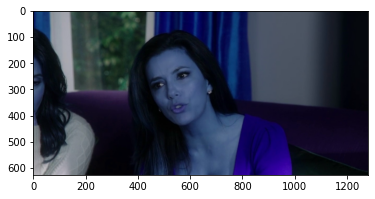

In [ ]:
import cv2 as cv
frame = chooseRandomImage()
frame = cv.imread(str("/content/DLproject/test/"+frame))
plt.imshow(frame)
plt.show()

In [ ]:
string_label(predict_emotion_of_frame(frame ,'Negative', model_face , model_res))

'Negative'